# Code for Chart Generation

## Imports and Loading the Data

In [1]:
import scanpy as sc
import os
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib
from scipy.stats import norm
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, leaves_list

## These lines are to fix saving PDF with text recognizible by Adobe Illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", category=UserWarning, module="scanpy")
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

my_random_seed = 666
n_cells_to_subsample = 3e3
n_cores = 8

sc.settings.n_jobs = int(n_cores)
sc.settings.set_figure_params(dpi=80,vector_friendly=False)

# Set the color palette
paper_color_palette = ["#FF7F0E","#F48FB1","#512DA8"]
sns.set_palette(paper_color_palette)

In [2]:
# Load in data
base = "/shares/vasciaveo_lab/data/nepc_organoid_project/new_data"
vp_data_path = os.path.join(base, "pyviper_h5ad_outputs/prot_act_concatenated.h5ad")
vp_data = sc.read_h5ad(vp_data_path)

# Load cancer hallmarks data
vp_cancer_hallmarks_path = os.path.join(base, "pyviper_h5ad_outputs/human_prot_act.h5ad")
vp_cancer_hallmarks = sc.read_h5ad(vp_cancer_hallmarks_path)
vp_cancer_hallmarks

adata_enr_path = os.path.join(base, "pyviper_h5ad_outputs/human_adata_anr.h5ad")
adata_enr = sc.read_h5ad(adata_enr_path)

## Ranking and Dimensionality Reduction

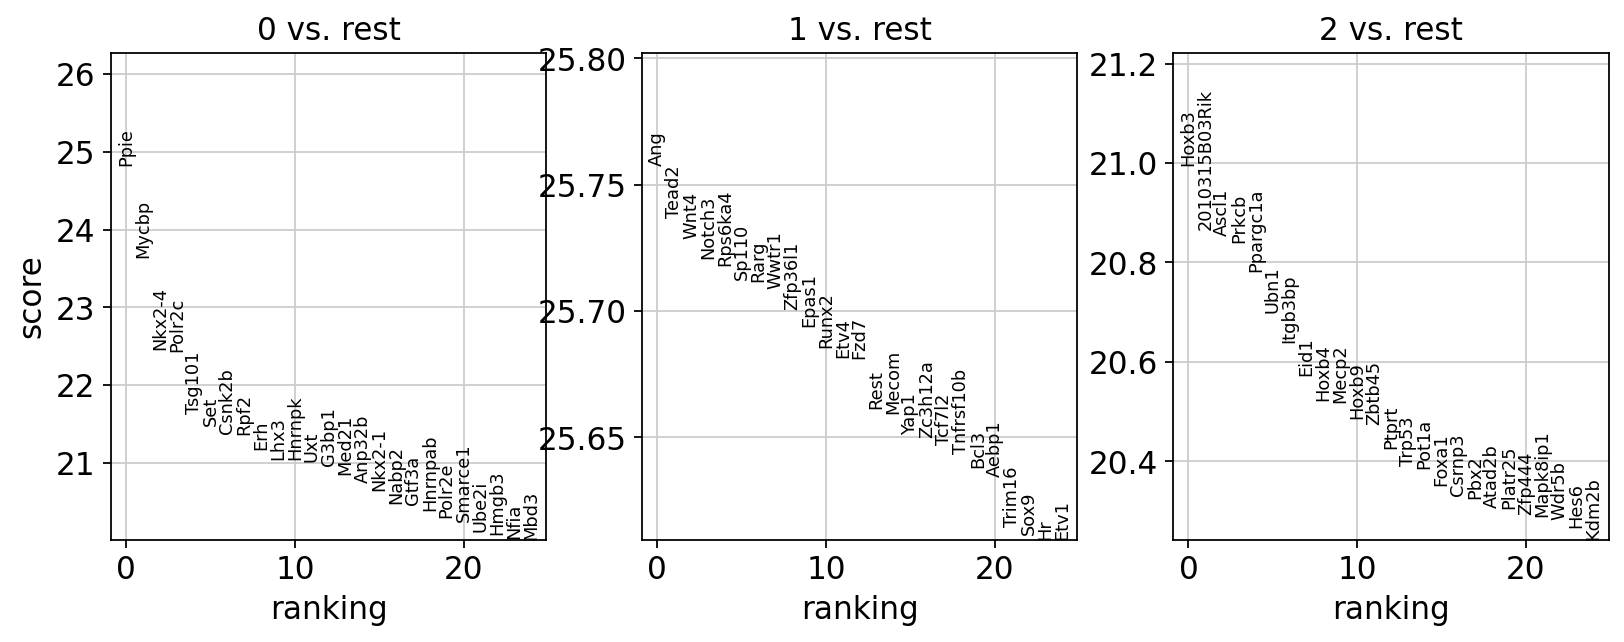

In [3]:
# Get subsampled data for analysis
vp_data_sub = sc.pp.sample(vp_data, n=1000 , rng=my_random_seed , copy=True) # it returns the subsampled adata
sc.tl.rank_genes_groups(vp_data_sub,
                        layer='mLog10' , 
                        groupby='leiden_pas' , method="wilcoxon" , corr_method="bonferroni")
sc.pl.rank_genes_groups(vp_data_sub, n_genes=25, sharey=False )

In [4]:
# Get gene group rankings
pd.DataFrame(vp_data_sub.uns['rank_genes_groups']['names']).head(10)
result = vp_data_sub.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_markers_proteins_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

print("Injecting Wilcoxon over 1000 cells into main data object vp_data")
vp_data.uns['rank_genes_groups'] = vp_data_sub.uns['rank_genes_groups']

Injecting Wilcoxon over 1000 cells into main data object vp_data


In [5]:
cluster_markers = {
    '1': {'Ar','Yap1','Wwtr1','Vim','Runx2'},        
    '2': {'Ppie','Set','Ptma','Atf4'},
    '3': {'Ascl1','Insm1','Chga','Nsd2','Hoxb3','Hoxb4'},
}
marker_matches = sc.tl.marker_gene_overlap(vp_data, cluster_markers)
marker_matches

0    1    2
1  0.0  3.0  0.0
2  4.0  0.0  0.0
3  0.0  0.0  4.0

In [6]:
vp_data.rename_categories('leiden_pas', marker_matches.idxmax())

/home/gaizenman/anaconda3/envs/my_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1093: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.uns[k1][k2].dtype.names = categories


In [7]:
# Get high-level relationships for clusters
print("Running PAGA ...")
sc.tl.paga(vp_data,groups="leiden_pas")
sc.pl.paga(vp_data, plot=False,random_state=my_random_seed)

print("Running UMAP Analysis initialized with PAGA ...")
sc.tl.umap(vp_data, n_components=3 , random_state=my_random_seed, init_pos='paga')

Running PAGA ...
Running UMAP Analysis initialized with PAGA ...


In [8]:
print("Re-Running KNN for DiffMap ...")
sc.pp.neighbors(vp_data, n_neighbors=15, n_pcs=10, 
                use_rep="X_pca_harmony", 
                key_added="knn_for_diffmap",
                random_state=my_random_seed)

print("Running Diffusion Map Analysis ...")
sc.tl.diffmap(vp_data, 
              neighbors_key = "knn_for_diffmap",
              random_state=my_random_seed)

# Bug Fix for Diffmap
vp_data.obsm["X_diffmap_"] = vp_data.obsm["X_diffmap"][:, 1:] 
vp_data.obsm["X_diffmap"] = vp_data.obsm["X_diffmap_"]

Re-Running KNN for DiffMap ...
Running Diffusion Map Analysis ...


In [9]:
vp_data.obs['leiden_pas'] = vp_data.obs['leiden_pas'].cat.reorder_categories(['1', '2', '3'], ordered=True) 

## Figure 1B

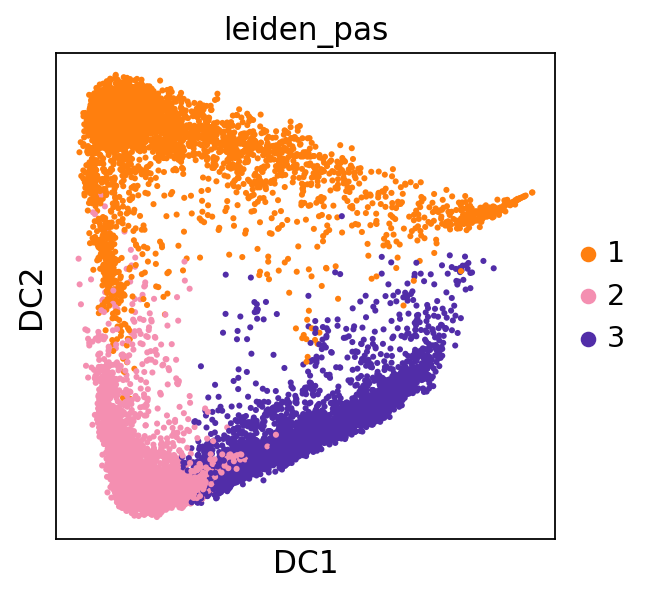

In [10]:
# Plot cells from only the necessary batches
batch = ["NPPO-2","NPPO-4","NPPO-1","NPPO-6","NPPO-5"]
cells_to_keep = [True if x in batch else False for x in vp_data.obs.sample_id_for_paper]
vp_data_sub = vp_data[cells_to_keep]

# Plot the diffusion component map
sc.pl.diffmap(vp_data_sub,color=["leiden_pas"], size=30 , palette=paper_color_palette , add_outline=False , save="-Figure-1B.pdf")

## Figure 1C

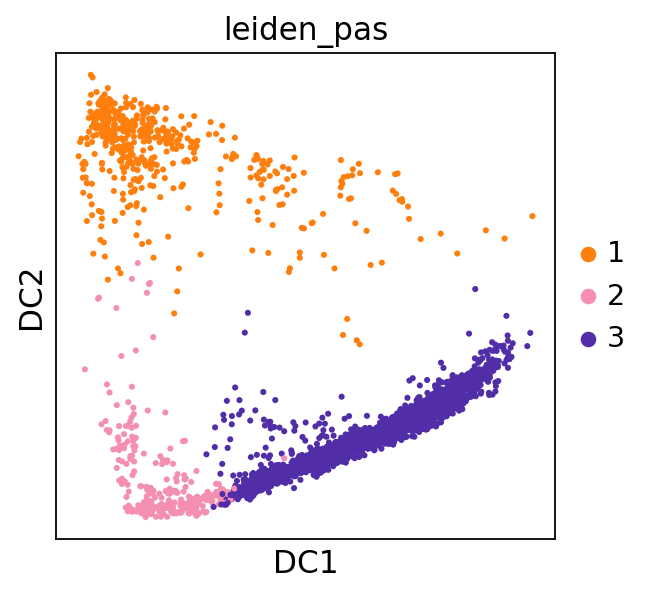

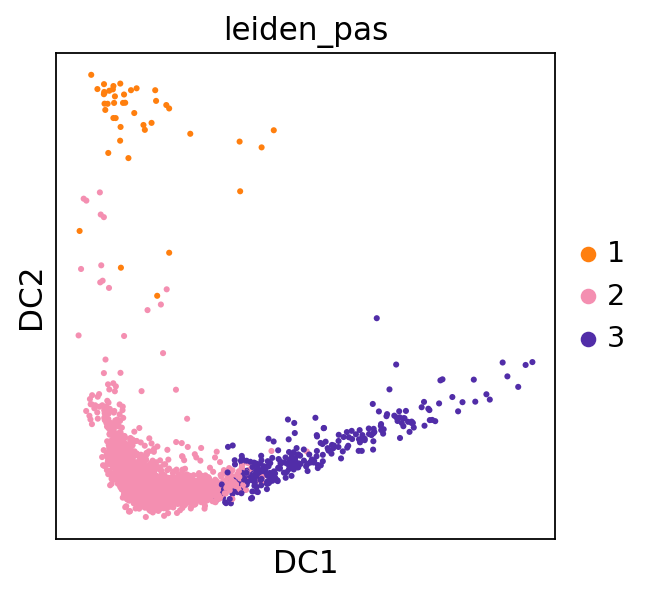

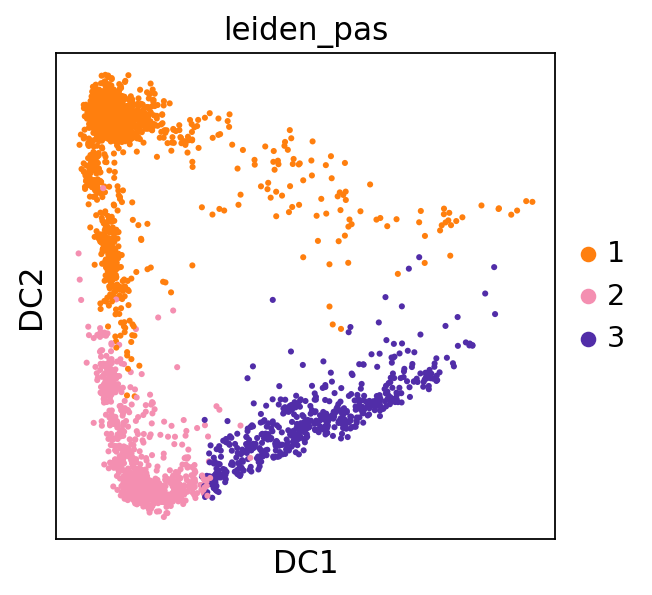

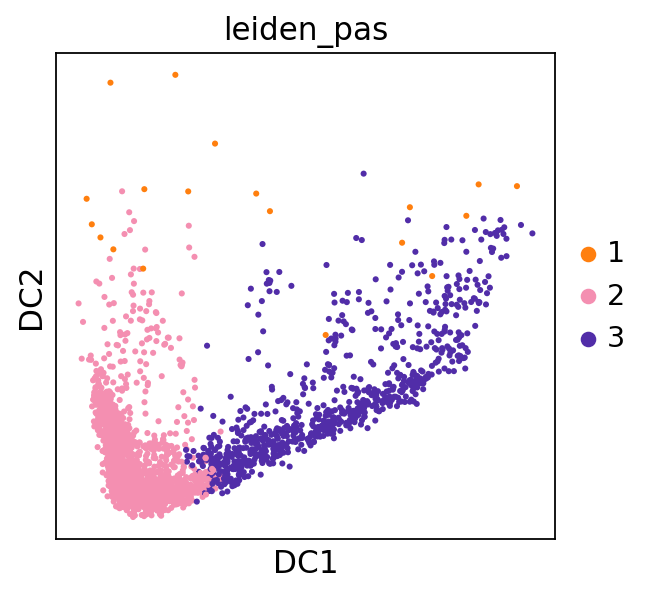

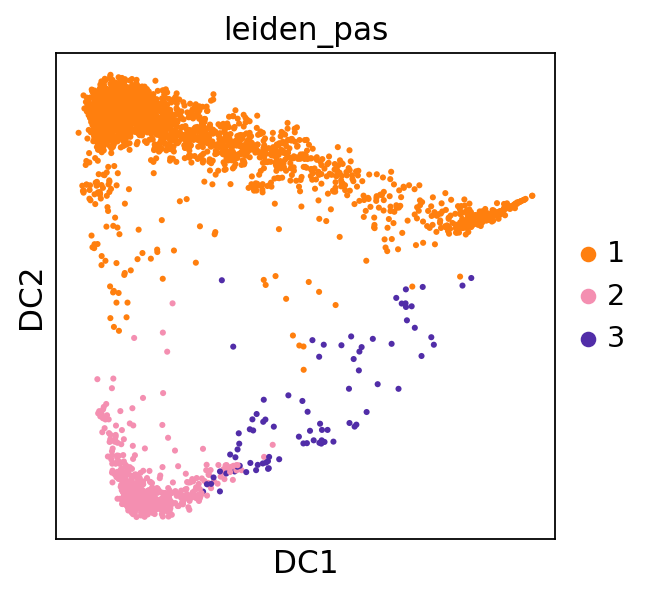

In [11]:
samples = ["NPPO-2","NPPO-4","NPPO-1","NPPO-6","NPPO-5"]

# Plot each sample's diffusion component map seprately
for batch in samples:
    cells_to_keep = [True if x in batch else False for x in vp_data.obs.sample_id_for_paper]
    vp_data_sub = vp_data[cells_to_keep]
    sc.pl.diffmap(vp_data_sub,color=["leiden_pas"], size=30 , palette=paper_color_palette , add_outline=False , save="-Figure-1C-sample-"+batch+".pdf")

## Figure 1D

In [ ]:
# batch = ["NPPO-2","NPPO-4","NPPO-1","NPPO-6","NPPO-5"]
# cells_to_keep = [True if x in batch else False for x in vp_pathways_nepc_ar.obs.sample_id_for_paper]
# # batch = ["scRNASeq"]
# # cells_to_keep = [True if x in batch else False for x in vp_pathways_nepc_ar.obs.technology]
# vp_pathways_nepc_ar_sub = vp_pathways_nepc_ar[cells_to_keep]
# sc.pl.diffmap(vp_pathways_nepc_ar_sub, color=["NEPC_beltran_2016","NEPC_beltran_2016"] , 
#               cmap = "RdBu_r" , vmin = -3 , vmax = 3 , palette=sc.pl.palettes.default_20 , 
#               show=False , 
#               return_fig=False , size = 30 , sort_order=True, 
#              save='-Figure-1D-Beltran.pdf' )

# batch = ["NPPO-2","NPPO-4","NPPO-1","NPPO-6","NPPO-5"]
# cells_to_keep = [True if x in batch else False for x in vp_pathways_nepc_ar.obs.sample_id_for_paper]
# # batch = ["scRNASeq"]
# # cells_to_keep = [True if x in batch else False for x in vp_pathways_nepc_ar.obs.technology]
# vp_data_sub = vp_data[cells_to_keep]
# # vp_data_sub.obs['ct_score'] = (vp_data_sub.obs['ct_score'] - vp_data_sub.obs['ct_score'].min()) / (vp_data_sub.obs['ct_score'].max() - vp_data_sub.obs['ct_score'].min())
# sc.pl.diffmap(vp_data, color=["ct_score","ct_score"] , 
#               cmap = "viridis" , palette=sc.pl.palettes.default_20 , 
#               show=False , 
#               return_fig=False , size = 30 , sort_order=True, 
#              save='Figure-1D-CytoTRACE.pdf' )

## Figure 1E

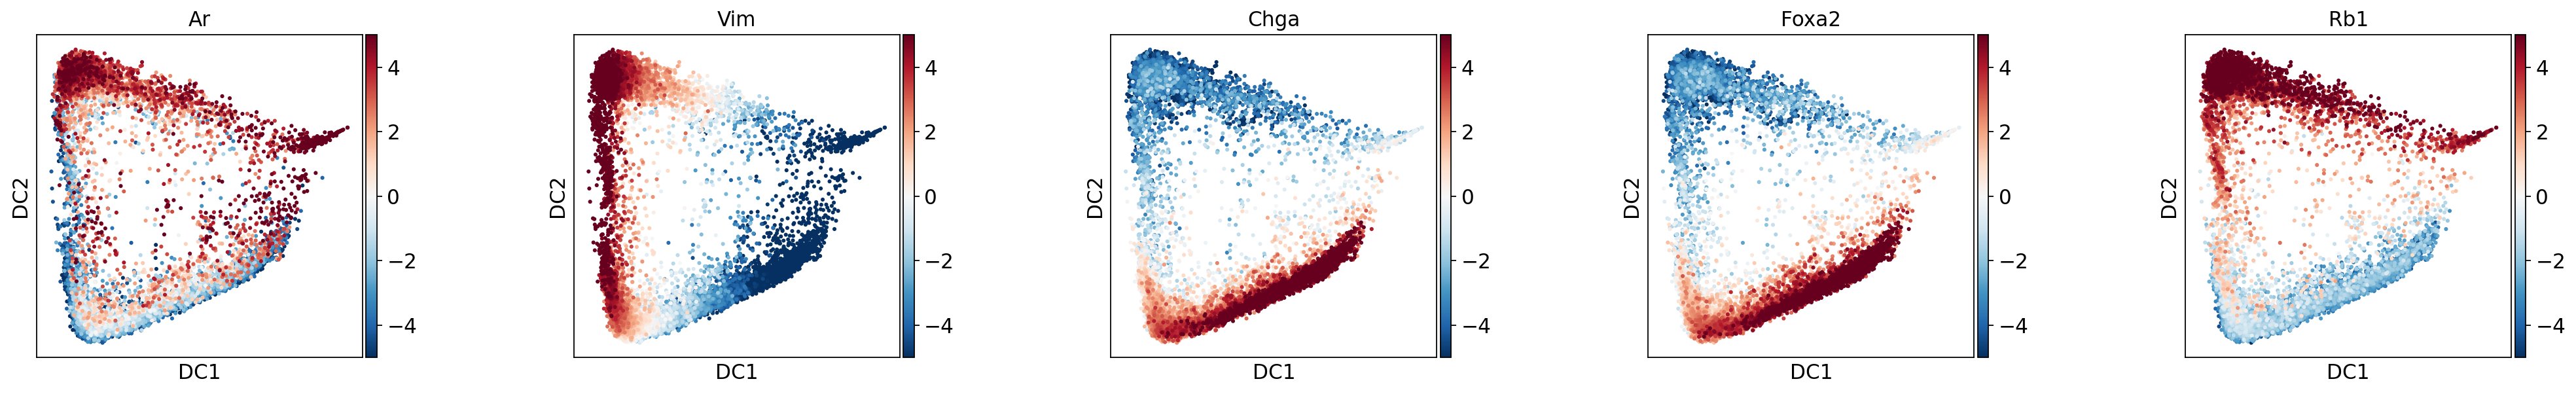

In [13]:
# Set the proteins to plot
set_of_proteins=["Ar","Vim","Chga","Foxa2","Rb1"]

batch = ["NPPO-2","NPPO-4","NPPO-1","NPPO-6","NPPO-5"]
cells_to_keep = [True if x in batch else False for x in vp_data.obs.sample_id_for_paper]
vp_data_sub = vp_data[cells_to_keep]

# Plot the diffusion map for each protein
sc.pl.diffmap(vp_data_sub, color=set_of_proteins , 
    cmap = "RdBu_r" , vmin = -5 , vmax = 5 , 
    ncols = 5 ,
    size = 30 ,
    palette=paper_color_palette , 
    add_outline = False ,
    wspace = 0.5 , save = "-Figure-1E.pdf" )

## Figure 1F

In [14]:
# Set the marker genes
marker_genes = [
    'Ar','Vim','Sox9','Twist1','Snai1','Zeb1','Myc','Hoxb13','Yap1','Nr3c1',"Foxa1","Foxa2","Pou3f2", 
    "Nsd2",'Kdm2a','Onecut2','Nkx3.1','Hoxb5','Hoxb6', "Dnmt3a","Crebbp","Ep300","Mki67" ,
    'Chga','Insm1','Ascl1',"Neurod1","Ezh2",'Sox2','Mycn']

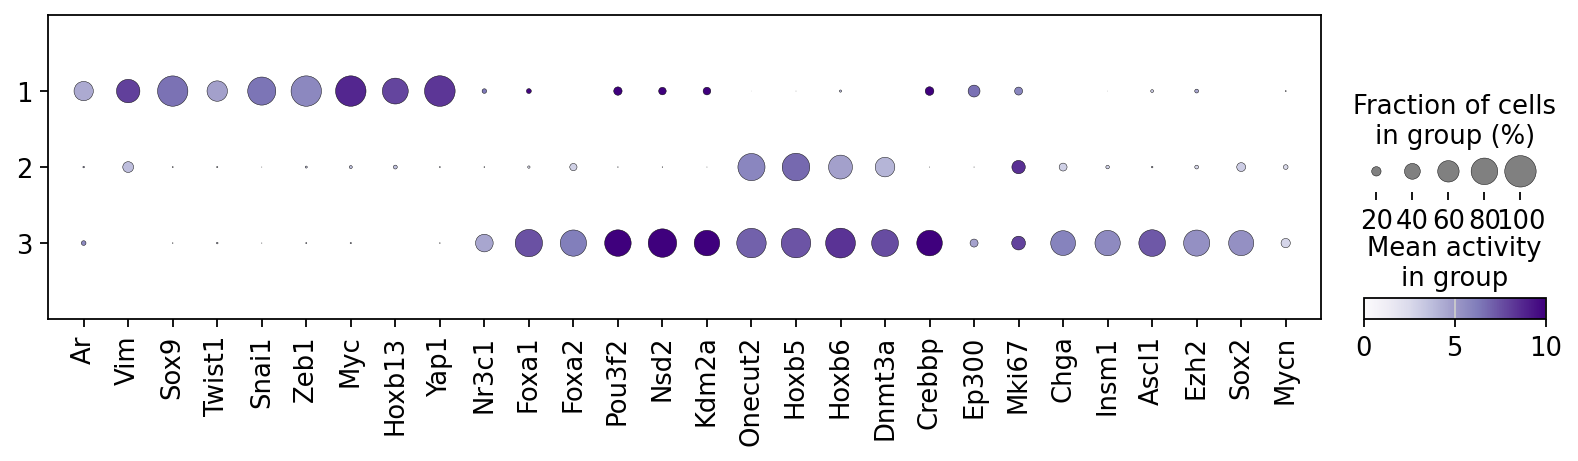

In [15]:
# Choose the batches to plot
batch = ['MJ002','MJ004','MJ005','MJ007','MJ008']

cells_to_keep = [True if x in batch else False for x in vp_data.obs.sample_id]
vp_data_sub = vp_data[cells_to_keep]

# Select only the marker genes present in the data
marker_genes_2 = [x for x in marker_genes if x in vp_data_sub.var_names]
dp = sc.pl.dotplot(vp_data_sub, marker_genes_2, groupby=['leiden_pas'], 
                   layer='mLog10' , 
                   expression_cutoff=2 ,mean_only_expressed=True, 
                   vmax = 10, dendrogram = False, figsize = [12,2.5],
                   cmap="Purples", colorbar_title='Mean activity\nin group',
                   save="-Figure-1F.pdf")

## Figure 3G

In [16]:
# Add diffmap and clusters to the protein activity data
vp_cancer_hallmarks.obsm['X_diffmap'] = vp_data.obsm['X_diffmap']
vp_cancer_hallmarks.obs['leiden_pas'] = vp_data.obs['leiden_pas']

/home/gaizenman/anaconda3/envs/my_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/gaizenman/anaconda3/envs/my_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/gaizenman/anaconda3/envs/my_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


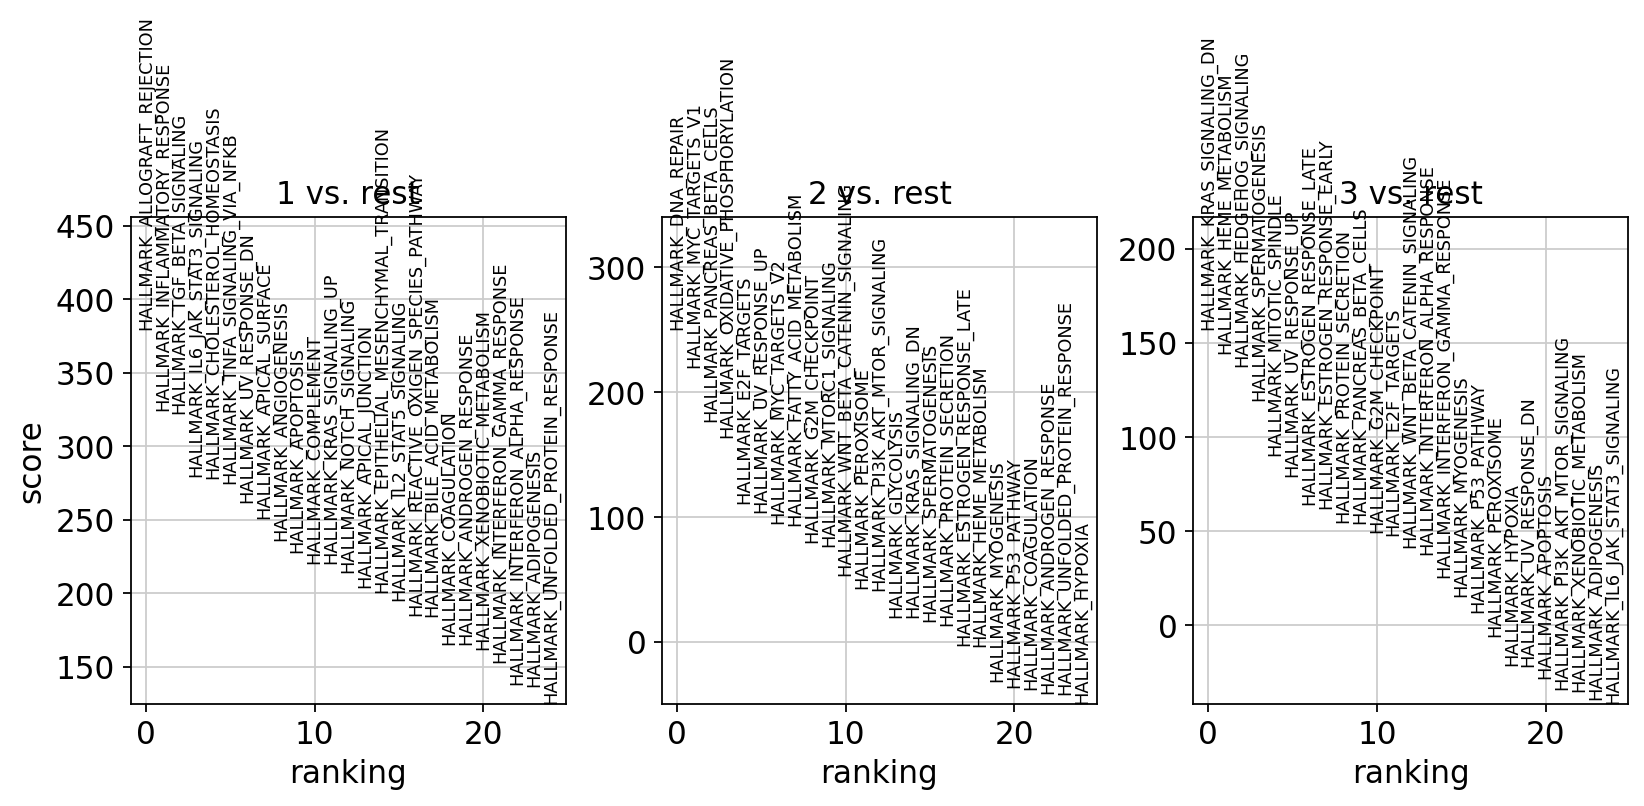

In [17]:
# Rank the gene groups
vp_cancer_hallmarks_sub = vp_cancer_hallmarks[vp_cancer_hallmarks.obs.technology == "scRNASeq"]
sc.tl.rank_genes_groups(vp_cancer_hallmarks_sub, 'leiden_pas' , method="t-test")
sc.pl.rank_genes_groups(vp_cancer_hallmarks_sub, n_genes=25, sharey=False )

In [18]:
# Set the top markers
top_markers = [
    'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION','HALLMARK_INFLAMMATORY_RESPONSE','HALLMARK_NOTCH_SIGNALING' ,'HALLMARK_IL6_JAK_STAT3_SIGNALING' , 'HALLMARK_TGF_BETA_SIGNALING' ,
    'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_DNA_REPAIR','HALLMARK_MYC_TARGETS_V1',"HALLMARK_G2M_CHECKPOINT",'HALLMARK_E2F_TARGETS']

1 MJ002_CGGCTAGCAGCTGCTG-1-MJ002-scRNASeq     True
MJ002_GTTAAGCGTAGCGATG-1-MJ002-scRNASeq    False
MJ002_GAGGTGAGTTTGTGTG-1-MJ002-scRNASeq    False
MJ002_GGGACCTTCGCTTGTC-1-MJ002-scRNASeq    False
MJ002_CAGTAACTCCCTGACT-1-MJ002-scRNASeq    False
                                           ...  
MJ015_AAGTGAACAAACGTGG-1-MJ015-scRNASeq    False
MJ015_GAGGGATAGCTAGAAT-1-MJ015-scRNASeq    False
MJ015_CTATCCGCACGTGAGA-1-MJ015-scRNASeq     True
MJ015_CGTGAATCAACTACGT-1-MJ015-scRNASeq     True
MJ015_ACTGTGAAGGCTAACG-1-MJ015-scRNASeq     True
Name: leiden_pas, Length: 21000, dtype: bool ['HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_INFLAMMATORY_RESPONSE', 'HALLMARK_NOTCH_SIGNALING', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_TGF_BETA_SIGNALING', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_DNA_REPAIR', 'HALLMARK_MYC_TARGETS_V1', 'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_E2F_TARGETS']
All markers are valid var_names!
2 MJ002_CGGCTAGCAGCTGCTG-1-MJ002-scRNASeq    False
MJ002_GTTAAGCGTAGCGATG-

/tmp/ipykernel_945985/3779740652.py:41: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  vp_cancer_hallmarks_sub_reordered.uns[f"{cluster_label}_colors"] = [


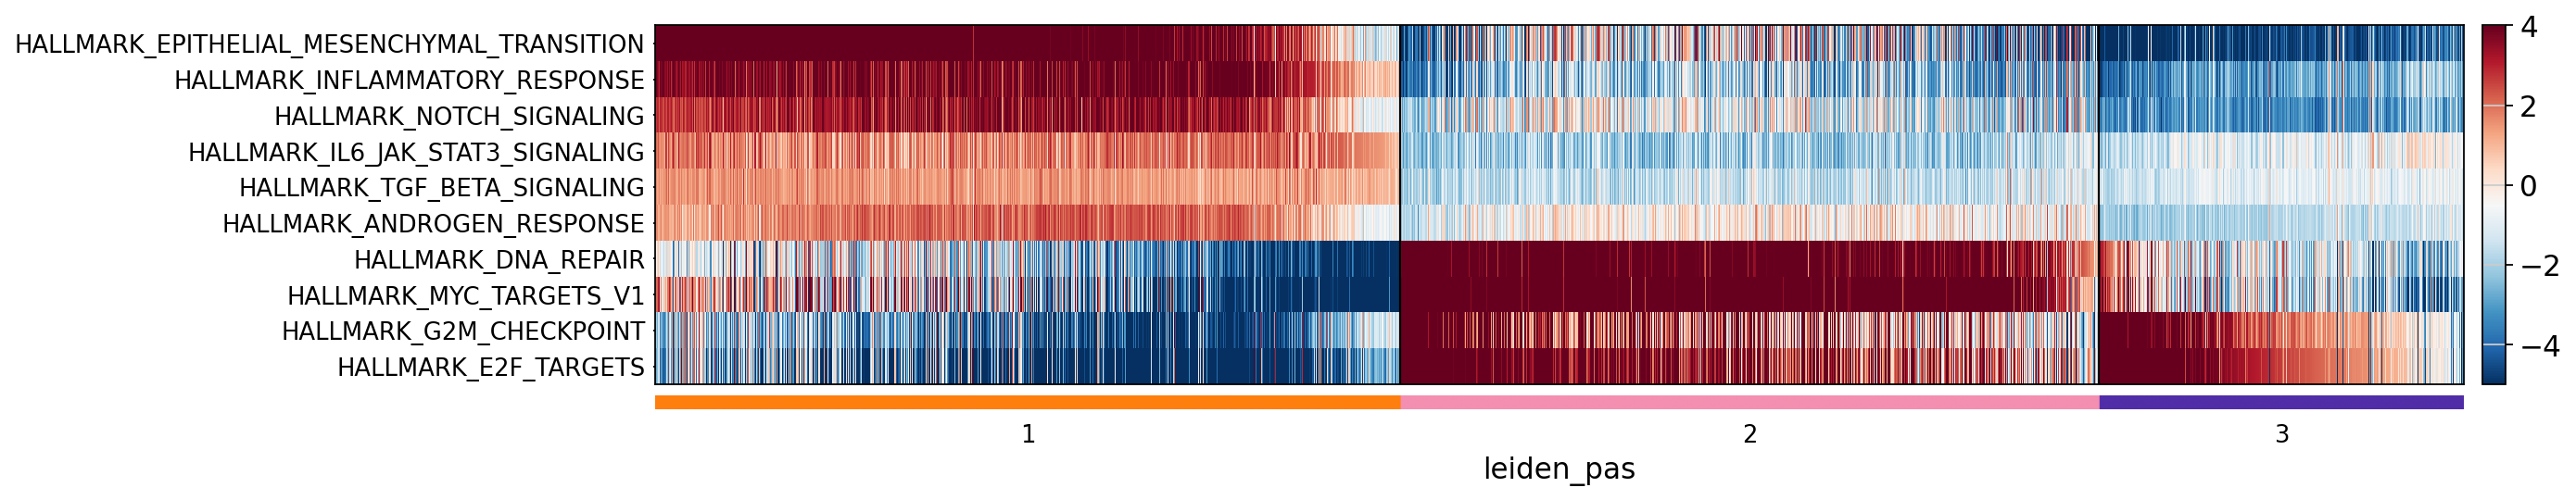

In [19]:
# Sort cells within each cluster by mean expression of top markers
clustered_indices = []
cluster_label = "leiden_pas"

for cluster in sorted(vp_cancer_hallmarks_sub.obs[cluster_label].unique()):
    # Get indices of cells in this cluster
    cluster_mask = vp_cancer_hallmarks_sub.obs[cluster_label] == cluster
    print(cluster, cluster_mask, top_markers)
    # all the feature names currently in your AnnData
    all_vars = set(vp_cancer_hallmarks_sub.var_names)

    # which of your markers aren’t present?
    missing = set(top_markers) - all_vars

    if missing:
        print("These markers are missing from adata.var_names:")
        for gene in sorted(missing):
            print("  ", gene)
    else:
        print("All markers are valid var_names!")
    cluster_data = vp_cancer_hallmarks_sub[cluster_mask, top_markers]
    
    # Compute mean expression across markers for each cell
    mean_expression = cluster_data.X.max(axis=1)
    
    # Convert to flat array if needed (depending on sparse/dense)
    if not isinstance(mean_expression, np.ndarray):
        mean_expression = mean_expression.A1 if hasattr(mean_expression, 'A1') else np.array(mean_expression).flatten()

    # Get indices of sorted cells within cluster
    sorted_cell_indices = cluster_data.obs_names[np.argsort(-mean_expression)]
    
    clustered_indices.extend(sorted_cell_indices)

# Reorder AnnData object
vp_cancer_hallmarks_sub_reordered = vp_cancer_hallmarks_sub[clustered_indices, :]

# 1. Get your cluster categories
categories = vp_cancer_hallmarks_sub_reordered.obs[cluster_label].cat.categories
# 2. Assign colors by index (make sure the list has enough colors)
vp_cancer_hallmarks_sub_reordered.uns[f"{cluster_label}_colors"] = [
    paper_color_palette[i] for i in range(len(categories))
]

# Plot
sc.pl.heatmap(
    vp_cancer_hallmarks_sub_reordered, top_markers, 
    groupby=cluster_label, show_gene_labels=True, cmap="RdBu_r", 
    show=True, use_raw=False, log=False, vmin=-5, vmax=4, 
    dendrogram=False, swap_axes=True, figsize=(16, 3.5), save="-Figure-1G"
)

## Figure 3B

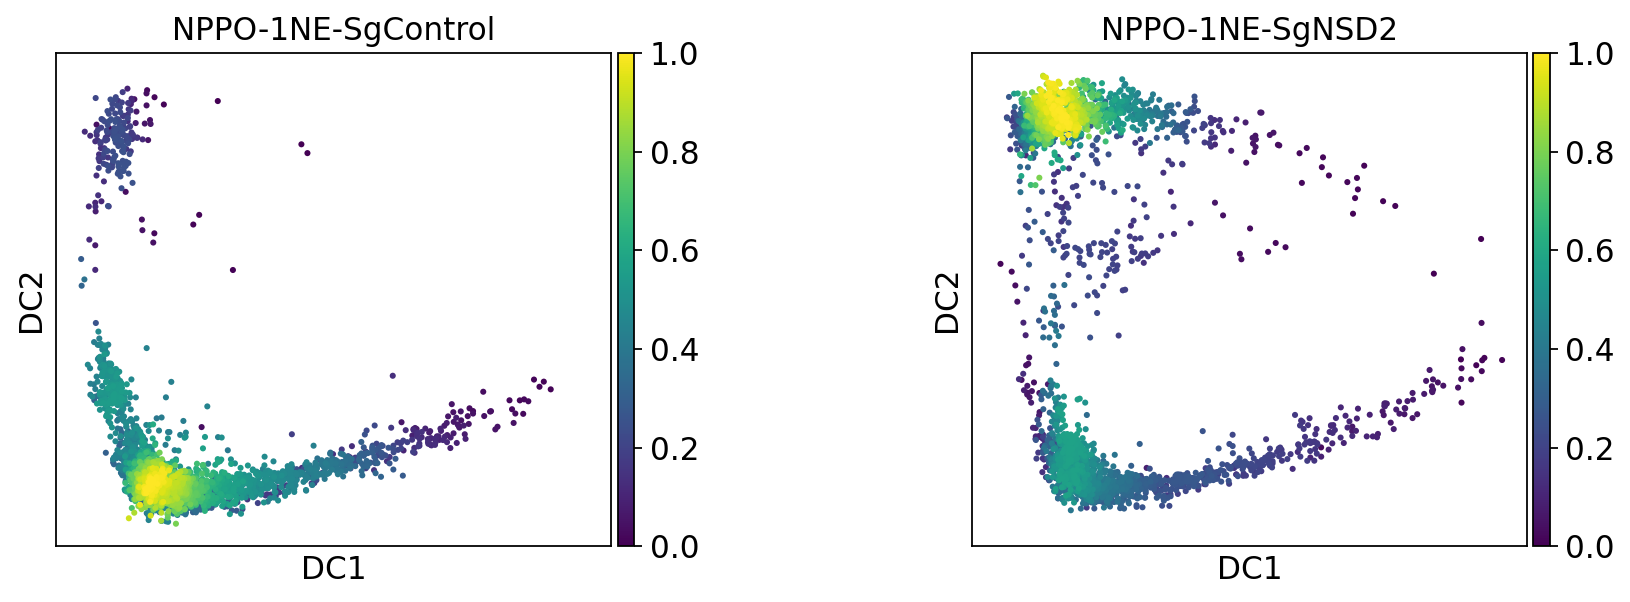

In [20]:
# Select necessary samples
batch = ["NPPO-1NE-SgControl","NPPO-1NE-SgNSD2"]
cells_to_keep = [True if x in batch else False for x in vp_data.obs.sample_id_for_paper]
vp_data_sub = vp_data[cells_to_keep]

# Plot embedding density
sc.tl.embedding_density(vp_data_sub ,  groupby='sample_id_for_paper' , key_added="sample_density")
sc.pl.embedding_density(vp_data_sub, basis = "diffmap" , key='sample_density' , wspace=0.5, fg_dotsize=30, bg_dotsize=0, color_map='viridis' , save="-Figure-3B.pdf" )

## Figure 3D

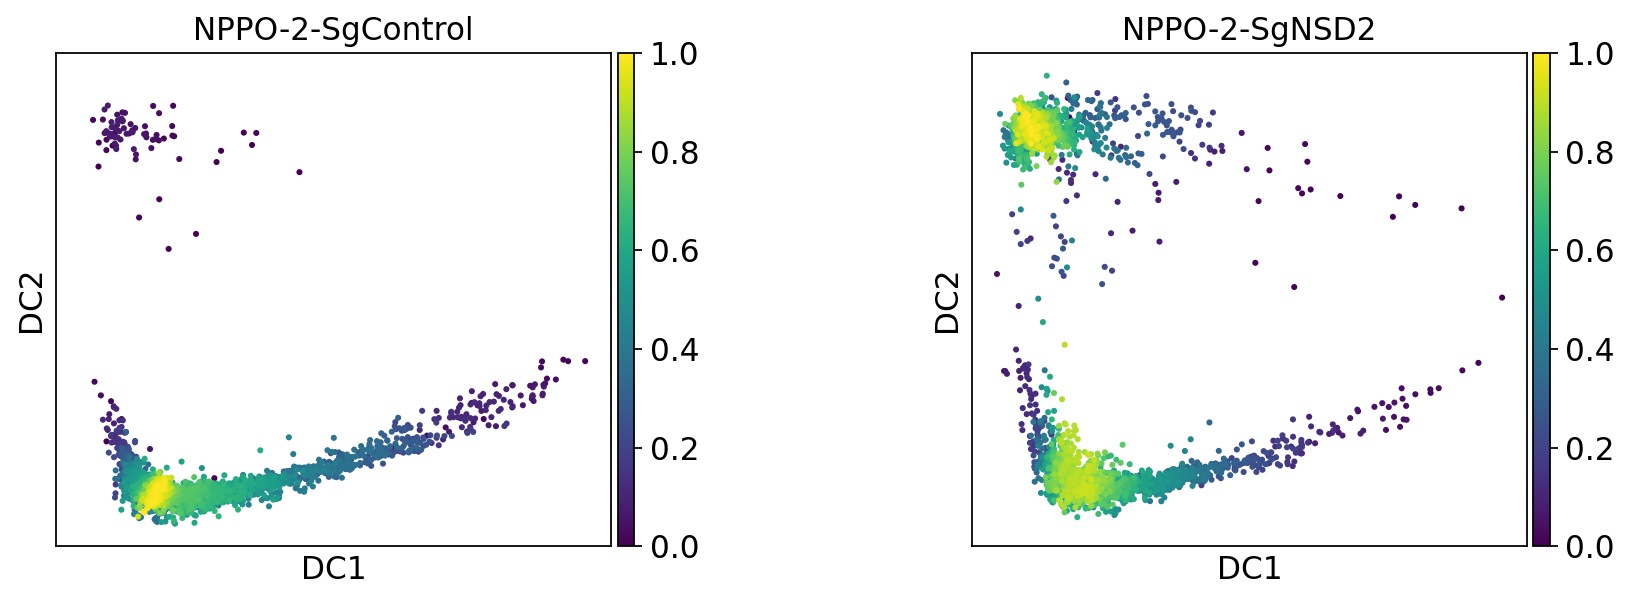

In [21]:
# Select necessary samples
batch = ["NPPO-2-SgControl","NPPO-2-SgNSD2"]
cells_to_keep = [True if x in batch else False for x in vp_data.obs.sample_id_for_paper]
vp_data_sub = vp_data[cells_to_keep]

# Plot embedding density
sc.tl.embedding_density(vp_data_sub ,  groupby='sample_id_for_paper' , key_added="sample_density")
sc.pl.embedding_density(vp_data_sub, basis = "diffmap" , key='sample_density' , wspace=0.5, fg_dotsize=30, bg_dotsize=0, color_map='viridis' , save="-Figure-3D.pdf" )


## adata_enr Analysis

In [22]:
# Add the diffusion component to the adata_enr
batch = ['snRNASeq']
cells_to_keep = [True if x in batch else False for x in vp_data.obs.technology]
vp_data_sub = vp_data[cells_to_keep]
adata_enr.obsm["X_diffmap"] = vp_data_sub.obsm["X_diffmap"]

# Add the mLog10 layer
adata_enr.layers['mLog10'] = -1*np.log10(norm.sf( adata_enr.X ))

## Figure 3F

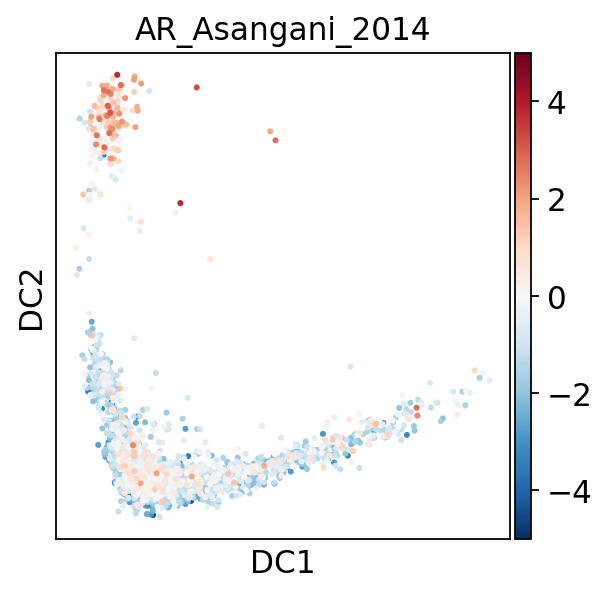

In [23]:
# Select the necessary samples
batch = ["NPPO-1NE-SgControl"]
cells_to_keep = [True if x in batch else False for x in adata_enr.obs.sample_id_for_paper]
adata_enr_sub = adata_enr[cells_to_keep]

# Plot the diffusion component map
sc.pl.diffmap(adata_enr_sub, color=['AR_Asangani_2014'],
                size=30, alpha=1, ncols=4,
                cmap="RdBu_r", vmin=-5, vmax=5, wspace=0.5,
                sort_order=True, save="-Figure-3F")

## Figure 3G

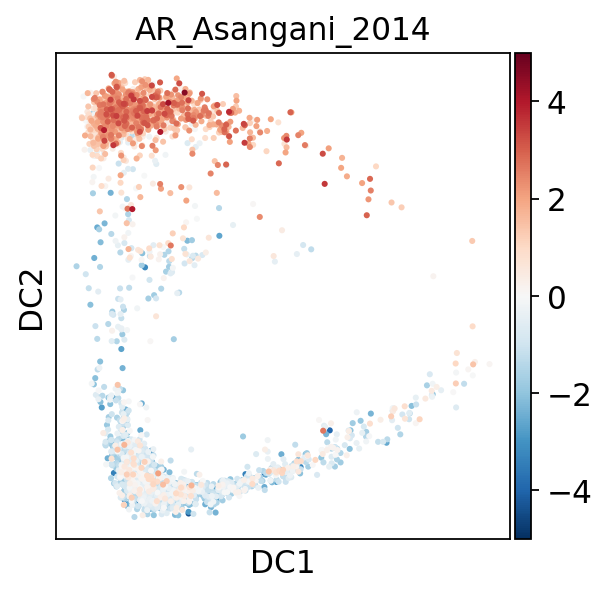

In [24]:
# Select the necessary samples
batch = ["NPPO-1NE-SgNSD2"]
cells_to_keep = [True if x in batch else False for x in adata_enr.obs.sample_id_for_paper]
adata_enr_sub = adata_enr[cells_to_keep]

# Plot the diffusion component map
sc.pl.diffmap(adata_enr_sub, color=['AR_Asangani_2014'],
                size=30, alpha=1, ncols=4,
                cmap="RdBu_r", vmin=-5, vmax=5, wspace=0.5,
                sort_order=True, save="-Figure-3G")

# EXTENDED DATA

## Extended Figure 2A

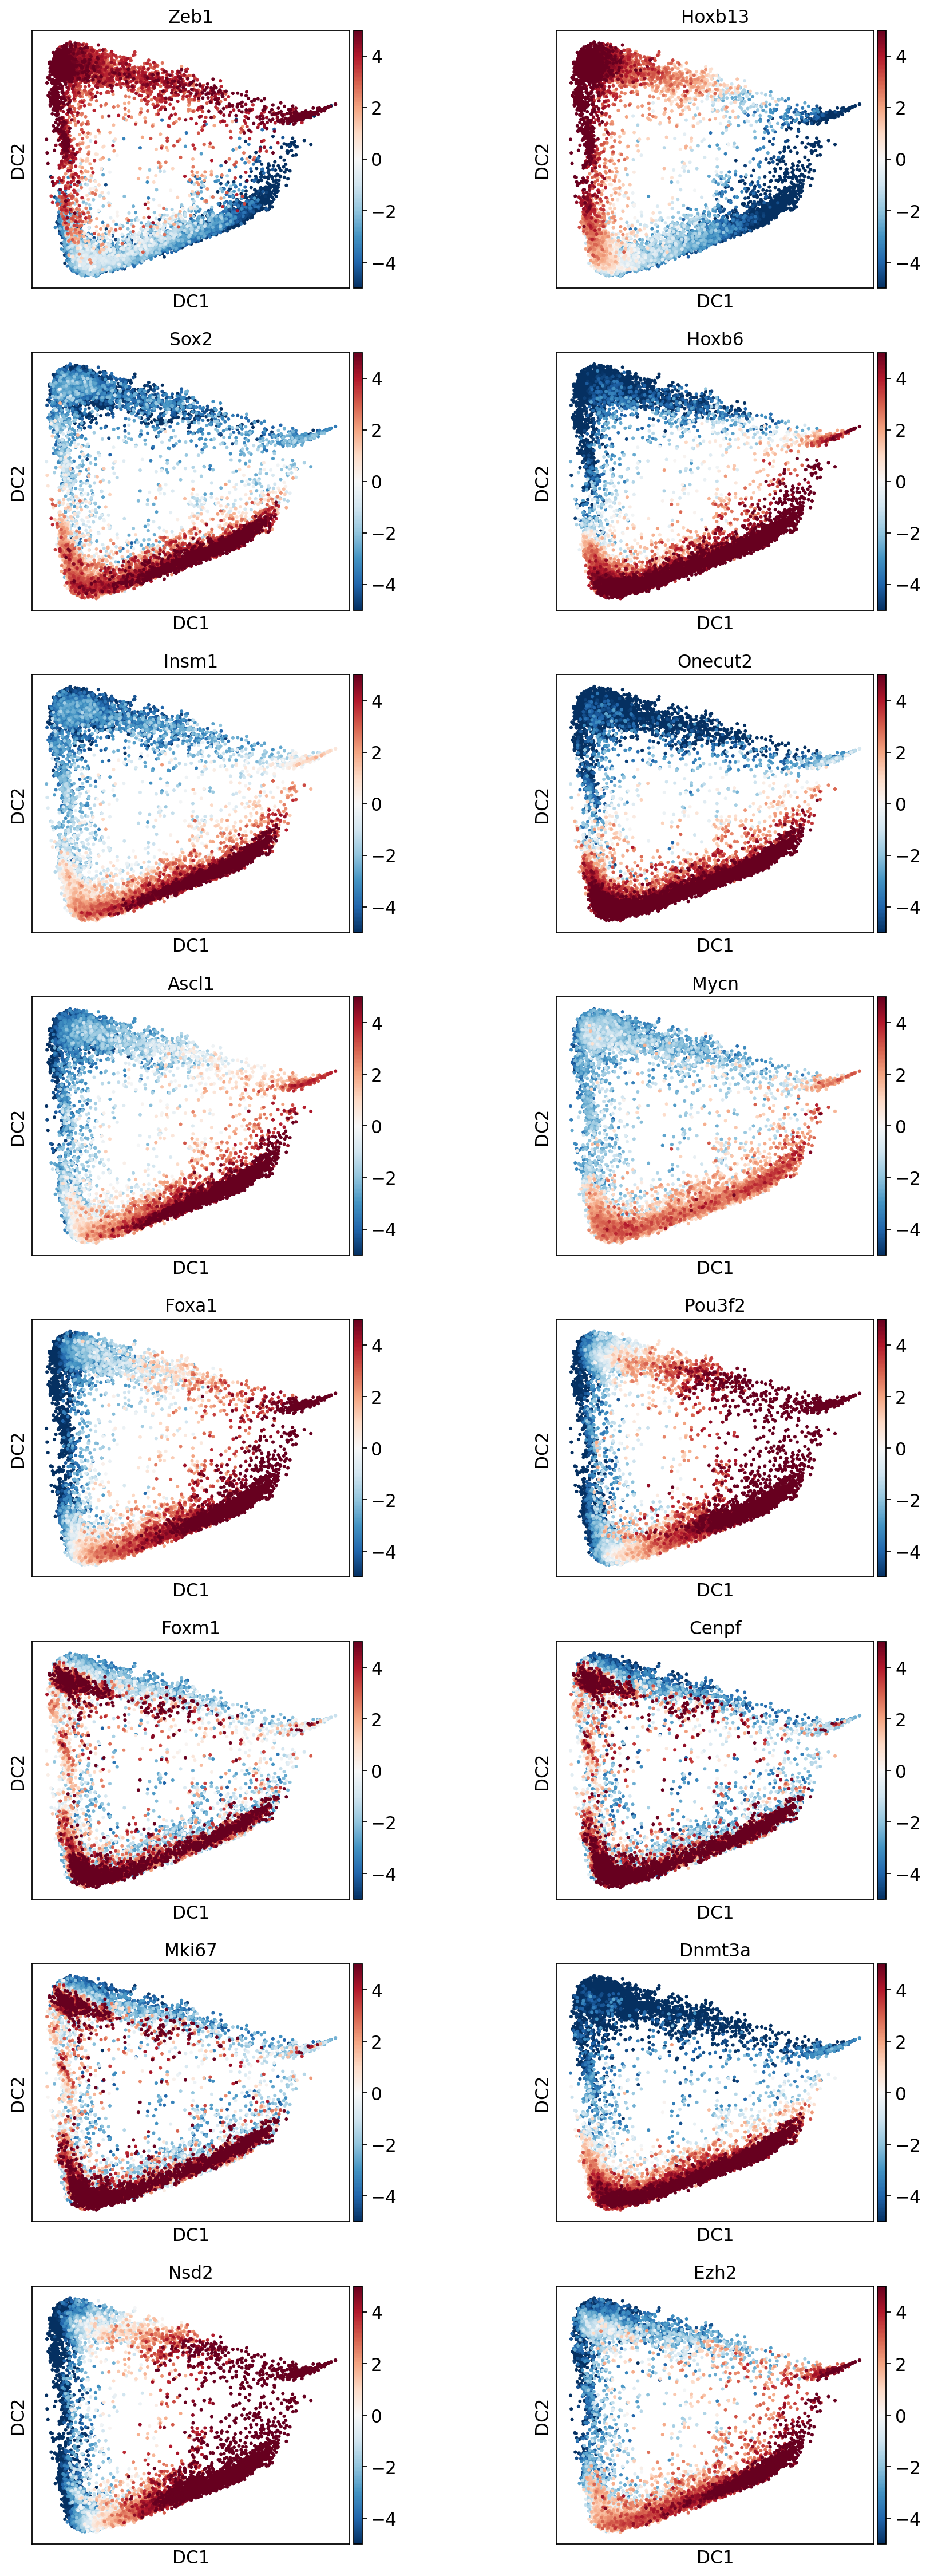

In [27]:
# Set the important proteins
set_of_proteins=['Zeb1','Hoxb13','Sox2','Hoxb6','Insm1','Onecut2','Ascl1','Mycn',
                 'Foxa1','Pou3f2','Foxm1','Cenpf','Mki67','Dnmt3a','Nsd2','Ezh2']

# Get only the necessary samples
batch = ["NPPO-2","NPPO-4","NPPO-1","NPPO-6","NPPO-5"]
cells_to_keep = [True if x in batch else False for x in vp_data.obs.sample_id_for_paper]
vp_data_sub = vp_data[cells_to_keep]

# Plot the diffmap
sc.pl.diffmap(vp_data_sub, color=set_of_proteins , 
    cmap = "RdBu_r" , vmin = -5 , vmax = 5 , 
    ncols = 2, size = 30, palette=paper_color_palette, 
    add_outline = False,
    wspace=0.5, save="-Extended-Figure-2A.pdf" )

## Extended Figure 2B

/tmp/ipykernel_945985/3939454011.py:49: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  vp_cancer_hallmarks_sub_reordered.uns[f"{cluster_label}_colors"] = [


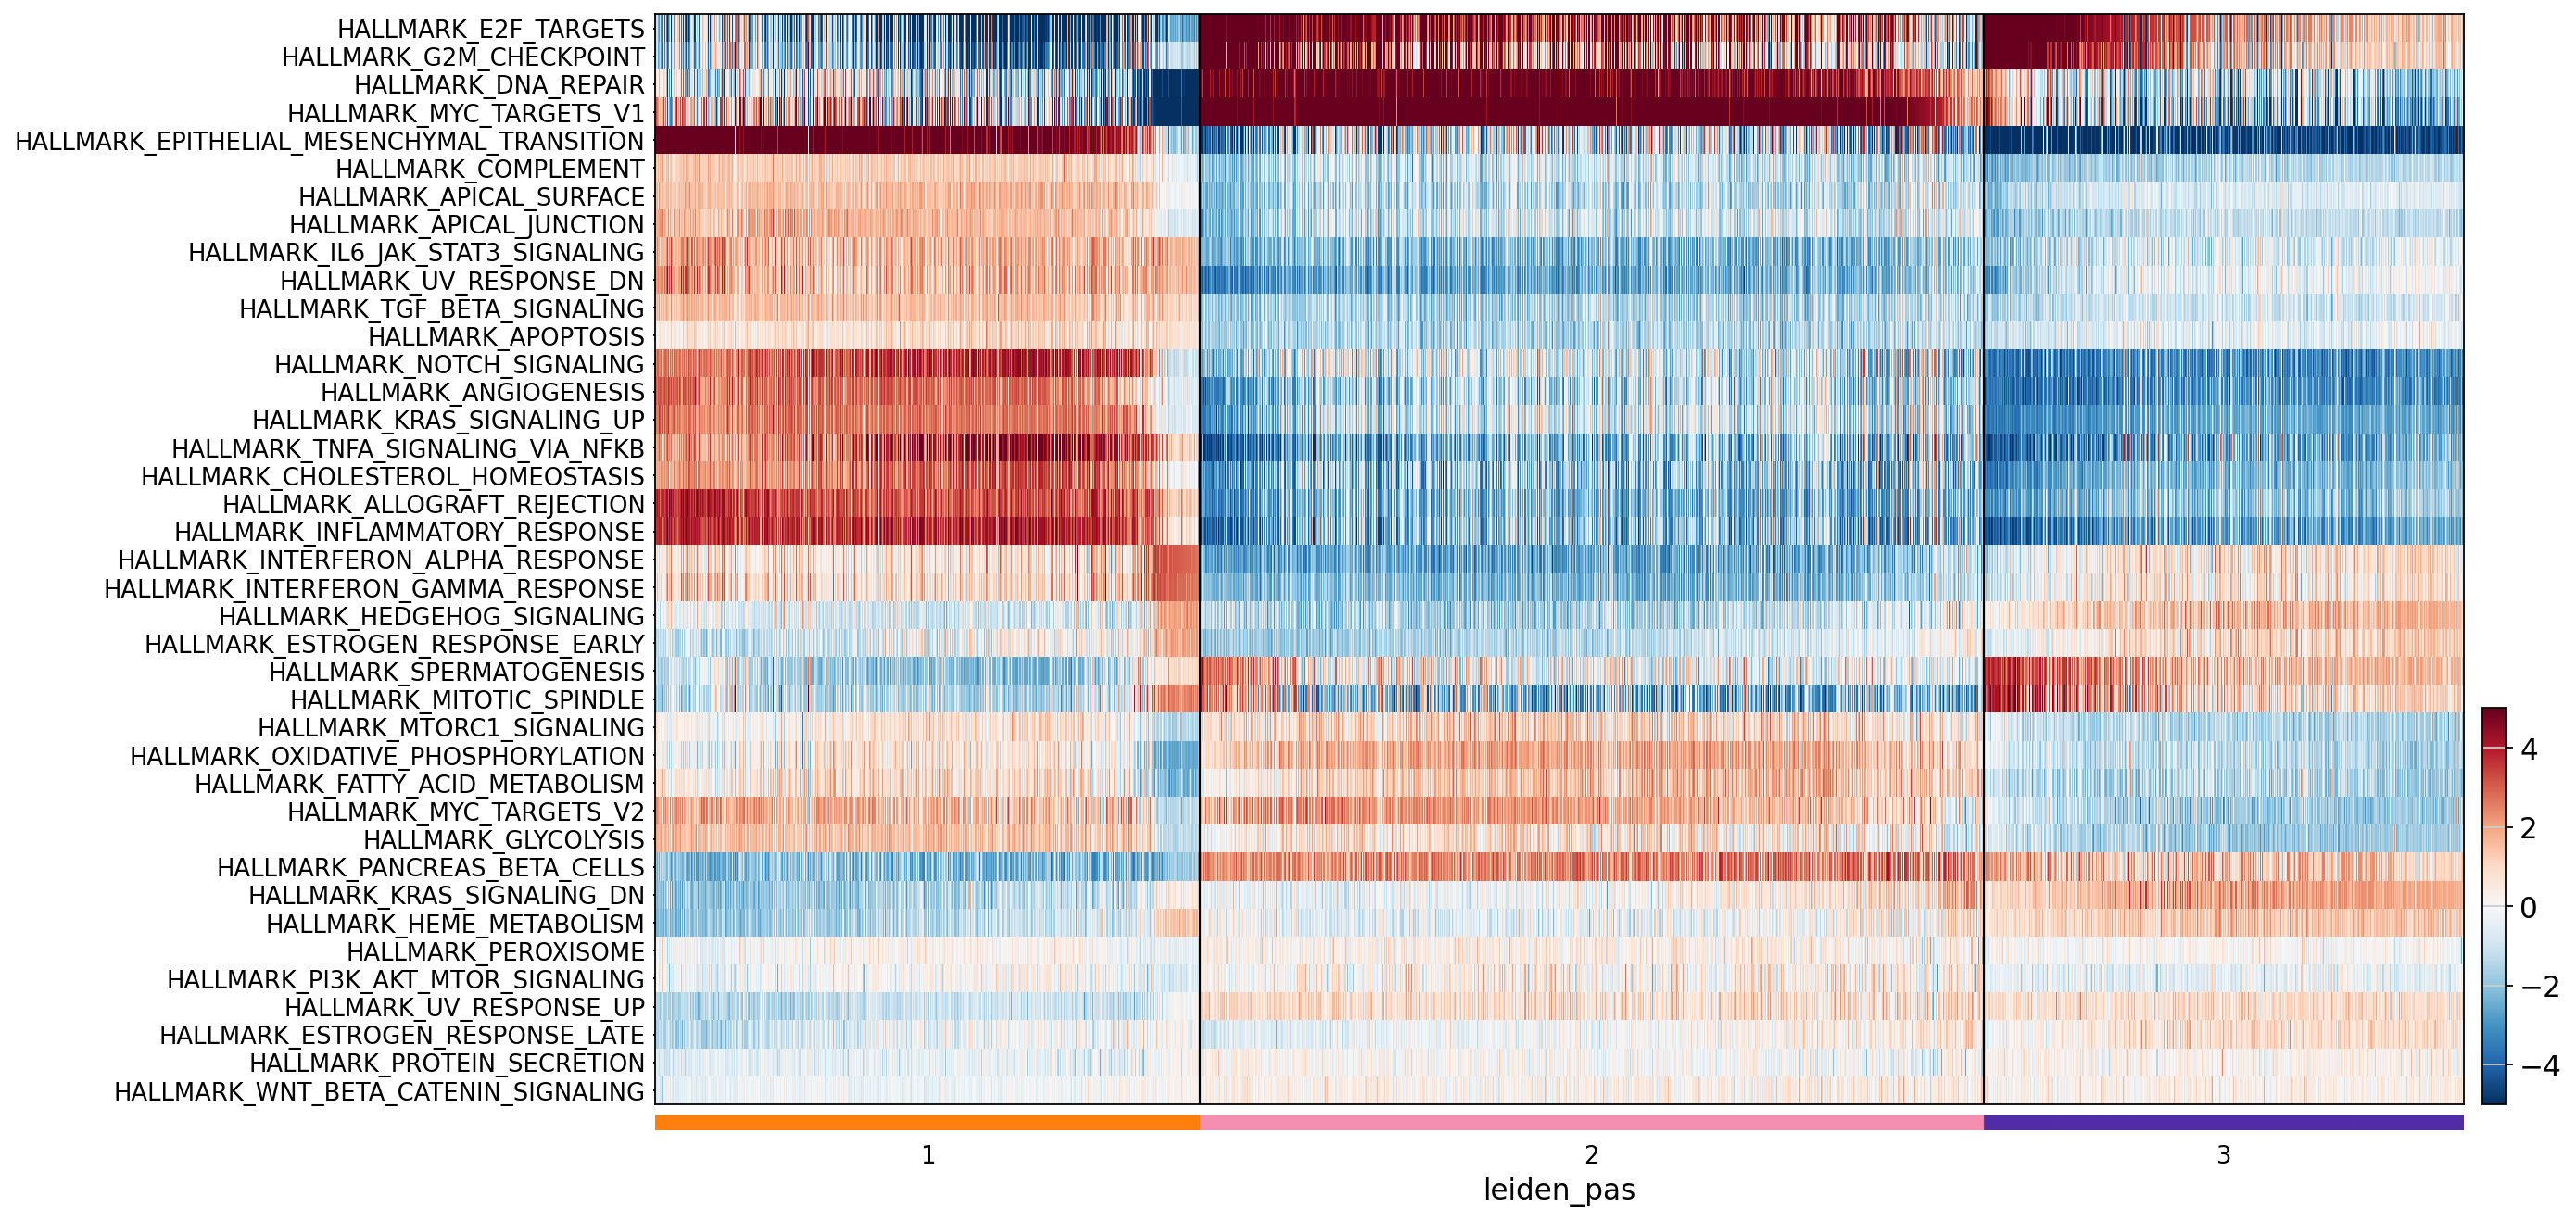

In [28]:
# Set only the necessary samples
batch = ['MJ002','MJ004','MJ005','MJ007','MJ008']

cells_to_keep = [True if x in batch else False for x in vp_cancer_hallmarks_sub.obs.sample_id]
vp_cancer_hallmarks_sub = vp_cancer_hallmarks_sub[cells_to_keep]

# Get top markers (already done earlier)
n_top = 15
cluster_label = "leiden_pas"
top_markers = [
    item for sublist in pd.DataFrame(
        vp_cancer_hallmarks_sub.uns['rank_genes_groups']['names']
    ).head(n_top).values.tolist() for item in sublist
]
top_markers = list(dict.fromkeys(top_markers))

# Cluster genes to reorder rows in heatmap
mat = vp_cancer_hallmarks_sub[:, top_markers].X.toarray()
linkage_matrix = linkage(mat.T, method='complete')
ordered_gene_indices = leaves_list(linkage_matrix)
top_markers_reordered = [top_markers[i] for i in ordered_gene_indices]

# Sort cells within each cluster by mean expression of top markers
clustered_indices = []

for cluster in sorted(vp_cancer_hallmarks_sub.obs[cluster_label].unique()):
    # Get indices of cells in this cluster
    cluster_mask = vp_cancer_hallmarks_sub.obs[cluster_label] == cluster
    cluster_data = vp_cancer_hallmarks_sub[cluster_mask, top_markers_reordered]
    
    # Compute mean expression across markers for each cell
    mean_expression = cluster_data.X.max(axis=1)
    
    # Convert to flat array if needed (depending on sparse/dense)
    if not isinstance(mean_expression, np.ndarray):
        mean_expression = mean_expression.A1 if hasattr(mean_expression, 'A1') else np.array(mean_expression).flatten()

    # Get indices of sorted cells within cluster
    sorted_cell_indices = cluster_data.obs_names[np.argsort(-mean_expression)]
    
    clustered_indices.extend(sorted_cell_indices)

# Reorder AnnData object
vp_cancer_hallmarks_sub_reordered = vp_cancer_hallmarks_sub[clustered_indices, :]

# 1. Get your cluster categories
categories = vp_cancer_hallmarks_sub_reordered.obs[cluster_label].cat.categories
# 2. Assign colors by index (make sure the list has enough colors)
vp_cancer_hallmarks_sub_reordered.uns[f"{cluster_label}_colors"] = [
    paper_color_palette[i] for i in range(len(categories))
]

# Plot the heatmap
sc.pl.heatmap(
    vp_cancer_hallmarks_sub_reordered, top_markers_reordered, 
    groupby=cluster_label, show_gene_labels=True, cmap="RdBu_r",
    use_raw=False, log=False, vmin=-5, vmax=5, 
    dendrogram=False, swap_axes=True, figsize=(16, 10), save="-Extended-Figure-2B.pdf"
)


## Extended Figure 5C

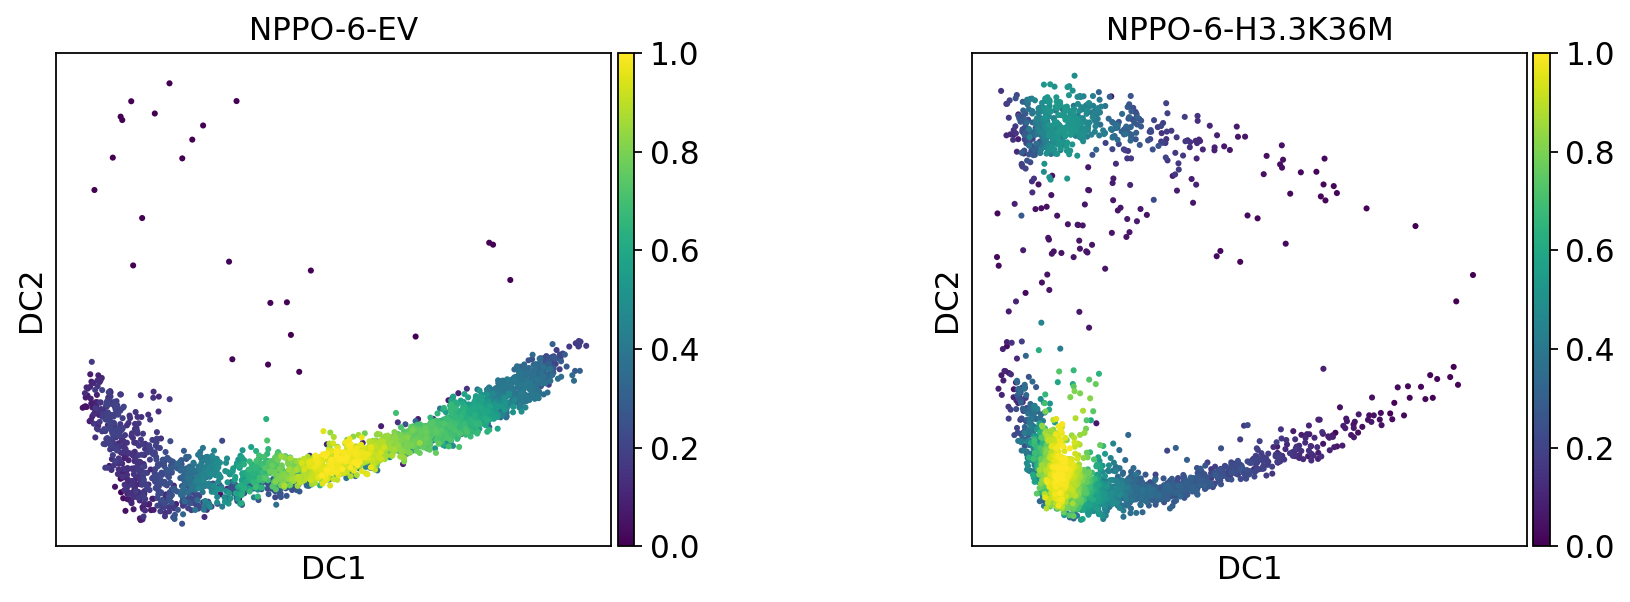

In [ ]:
# Select necessary samples
batch = ["NPPO-6-EV","NPPO-6-H3.3K36M"]
cells_to_keep = [True if x in batch else False for x in vp_data.obs.sample_id_for_paper]
vp_data_sub = vp_data[cells_to_keep]

# Plot embedding density
sc.tl.embedding_density(vp_data_sub ,  groupby='sample_id_for_paper' , key_added="sample_density")
sc.pl.embedding_density(vp_data_sub, basis = "diffmap" , key='sample_density' , wspace=0.5, fg_dotsize=30, bg_dotsize=0, color_map='viridis' , save="-Extended-Figure-5C.pdf" )


## Extended Figure 8G

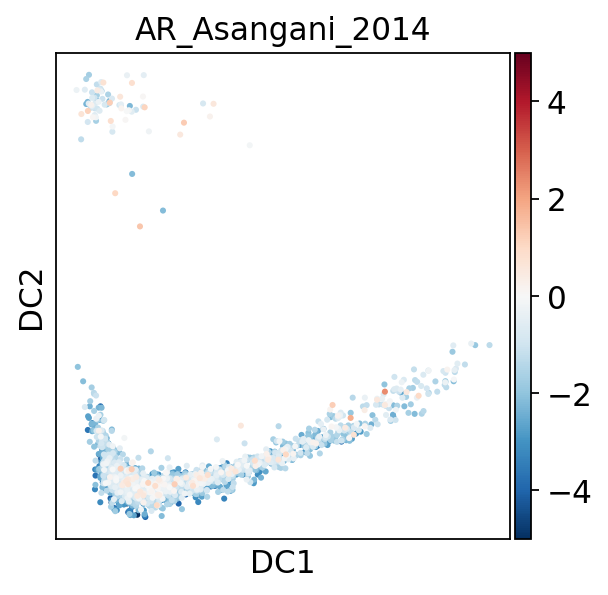

In [29]:
# Select the necessary samples
batch = ["NPPO-2-SgControl"]
cells_to_keep = [True if x in batch else False for x in adata_enr.obs.sample_id_for_paper]
adata_enr_sub = adata_enr[cells_to_keep]

# Plot the diffusion component map
sc.pl.diffmap(adata_enr_sub, color=['AR_Asangani_2014'],
                size=30, alpha=1, ncols=4,
                cmap="RdBu_r", vmin=-5, vmax=5, wspace=0.5,
                sort_order=True, save="-Extended-Figure-8G")

## Extended Figure 8H

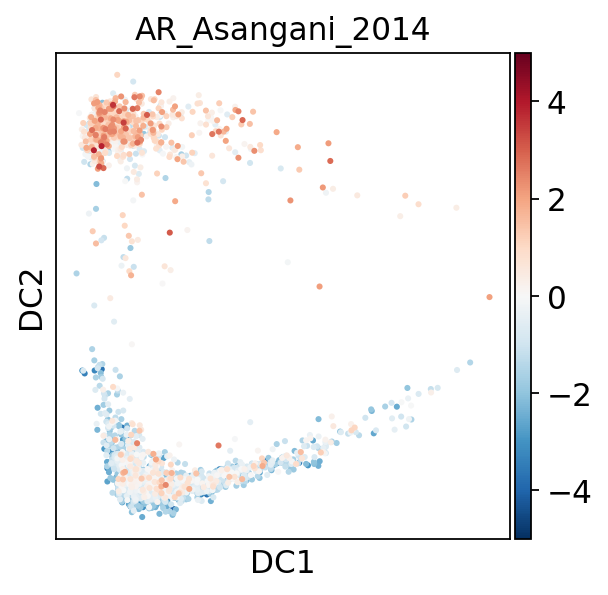

In [31]:
# Select the necessary samples
batch = ["NPPO-2-SgNSD2"]
cells_to_keep = [True if x in batch else False for x in adata_enr.obs.sample_id_for_paper]
adata_enr_sub = adata_enr[cells_to_keep]

# Plot the diffusion component map
sc.pl.diffmap(adata_enr_sub, color=['AR_Asangani_2014'],
                size=30, alpha=1, ncols=4,
                cmap="RdBu_r", vmin=-5, vmax=5, wspace=0.5,
                sort_order=True, save="-Extended-Figure-8H")

## Extended Figure 8I

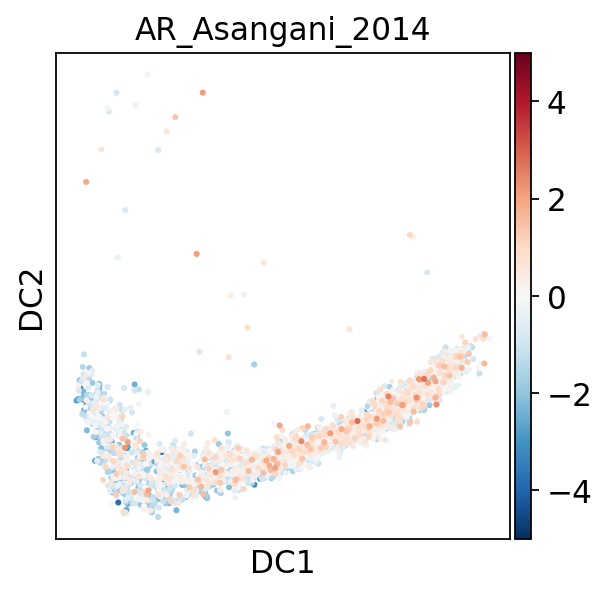

In [32]:
# Select the necessary samples
batch = ["NPPO-6-EV"]
cells_to_keep = [True if x in batch else False for x in adata_enr.obs.sample_id_for_paper]
adata_enr_sub = adata_enr[cells_to_keep]

# Plot the diffusion component map
sc.pl.diffmap(adata_enr_sub, color=['AR_Asangani_2014'],
                size=30, alpha=1, ncols=4,
                cmap="RdBu_r", vmin=-5, vmax=5, wspace=0.5,
                sort_order=True, save="-Extended-Figure-8I")

## Extended Figure 8J

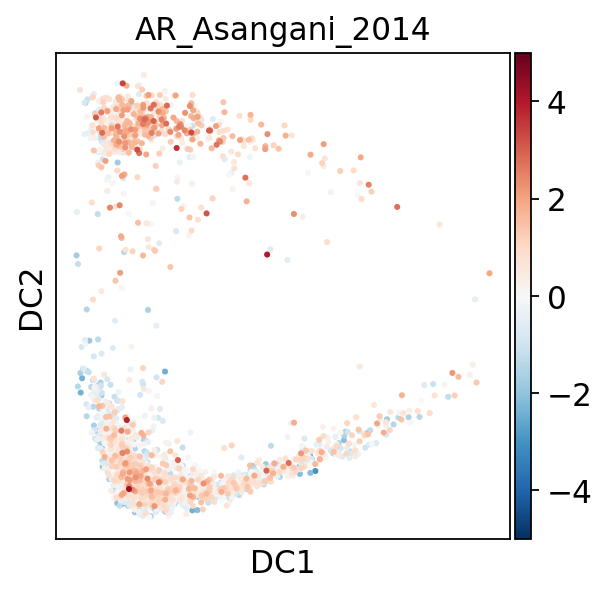

In [33]:
# Select the necessary samples
batch = ["NPPO-6-H3.3K36M"]
cells_to_keep = [True if x in batch else False for x in adata_enr.obs.sample_id_for_paper]
adata_enr_sub = adata_enr[cells_to_keep]

# Plot the diffusion component map
sc.pl.diffmap(adata_enr_sub, color=['AR_Asangani_2014'],
                size=30, alpha=1, ncols=4,
                cmap="RdBu_r", vmin=-5, vmax=5, wspace=0.5,
                sort_order=True, save="-Extended-Figure-8J")

## Extended Figure 9E

In [52]:
# Method 2: if it’s a Categorical, `.cat.categories` gives you the full set of defined categories
print(vp_data.obs['sample_id_for_paper'].cat.categories)


Index(['NPPO-1', 'NPPO-1NE+NPPO-1nonNE-LV-RFP', 'NPPO-1NE-SgControl',
       'NPPO-1NE-SgNSD2', 'NPPO-1NE_DMSO', 'NPPO-1NE_KTX-1001',
       'NPPO-1non-NE-LV-RFP', 'NPPO-2', 'NPPO-2-SgControl', 'NPPO-2-SgNSD2',
       'NPPO-4', 'NPPO-5', 'NPPO-6', 'NPPO-6-EV', 'NPPO-6-H3.3K36M'],
      dtype='object')


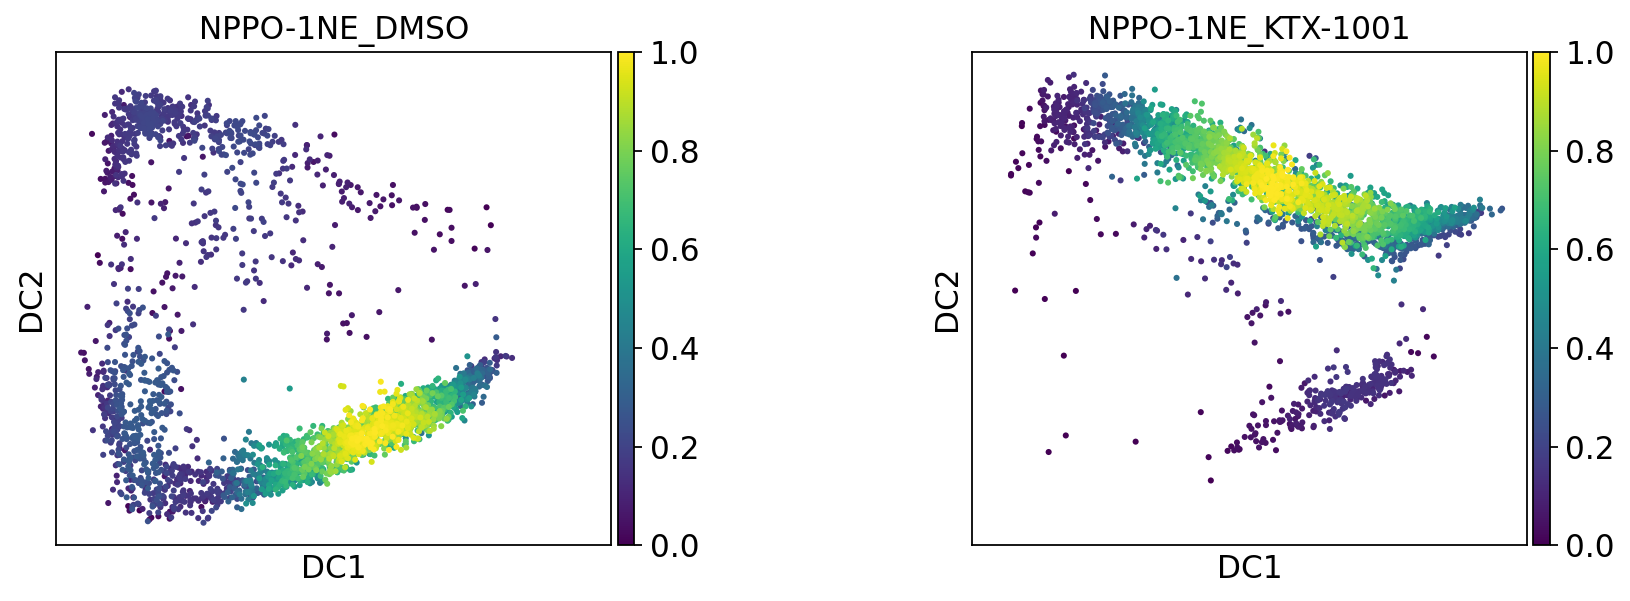

In [56]:
# Select necessary samples
batch = ['NPPO-1NE_DMSO','NPPO-1NE_KTX-1001']
cells_to_keep = [True if x in batch else False for x in vp_data.obs.sample_id_for_paper]
vp_data_sub = vp_data[cells_to_keep]

# Plot embedding density
sc.tl.embedding_density(vp_data_sub ,  groupby='sample_id_for_paper' , key_added="sample_density")
sc.pl.embedding_density(vp_data_sub, basis = "diffmap" , key='sample_density' , wspace=0.5, fg_dotsize=30, bg_dotsize=0, color_map='viridis' , save="-Extended-Figure-9E.pdf" )


# OLD CODE

## Cytotrace Scores

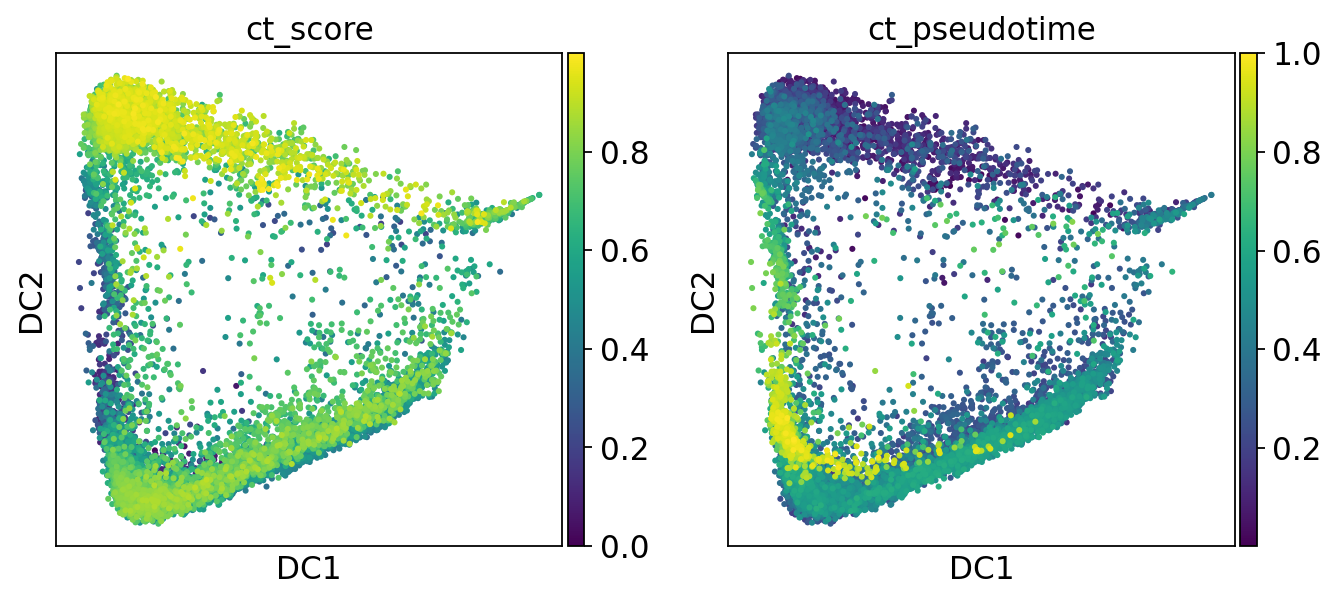

In [57]:
# Plot the DiffMap with CytoScores
batch = ["NPPO-2","NPPO-4","NPPO-1","NPPO-6","NPPO-5"]
cells_to_keep = [True if x in batch else False for x in vp_data.obs.sample_id_for_paper]
vp_data_sub = vp_data[cells_to_keep]
sc.pl.diffmap(vp_data_sub, color=["ct_score","ct_pseudotime"] , cmap = "viridis" , palette=sc.pl.palettes.default_20 , show=True , return_fig=False , sort_order = True, size = 30 ,
             save='-'+'-'.join(map(str,batch)) + "-samples-diffmap-cytotrace.pdf" )